In [1]:
# Dependencies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define URL parameters
league_id = 730129
year = 2022
week = 1

In [3]:
# Define cookie parameters
espn_s2 = 'AECZN3TKoAklaZcwsKeLKJnSoCjOS%2BJwDSbNr9I%2FHZdaZZKiF5ZmCr6Em0mzCY%2FkhpewlrMf2pXXExD6YJfBH3WvrlJ2T0TrstCJb2jhKSUVu5KaizTWVctSb8fXo1cQ3pCMiuHjSvFSnEM%2Baj8JKzWNCg1RfNio7WyKMggpem7BCKYQrqd4ZMyyvhUX%2BZKe4kGSSmJ%2Ff5kd1jTyvi5R%2B1OUd3G5c9ot4%2Fhvyt1MzgPQjW6v59hDlEJaTFpBNWlLwrGb8khRLPYpsy9AY3%2F6mqNZrKanKRrE0sk1jjMu%2Fe1sVQ%3D%3D'
swid = '{E876EBB1-2C60-45B7-94AA-1611AD9AC4A3}'

In [4]:
# Define the URL with our parameters
url = f"https://fantasy.espn.com/apis/v3/games/ffl/seasons/{year}/segments/0/leagues/{league_id}"

In [5]:
# Pull team and matchup data from the URL
matchup_response = requests.get(url, 
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mMatchup"},
                               cookies={"swid" : swid,
                                       "espn_s2" : espn_s2})

team_response = requests.get(url, 
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mTeam"},
                               cookies={"swid" : swid,
                                       "espn_s2" : espn_s2},)

In [6]:
# Transform the response into a json
matchup_json = matchup_response.json()
team_json = team_response.json()

In [7]:
# Transform both of the json outputs into DataFrames
matchup_df = pd.json_normalize(matchup_json['schedule'])
team_df = pd.json_normalize(team_json['teams'])

In [8]:
# Define the column names needed
matchup_column_names = {
    'matchupPeriodId':'Week', 
    'away.teamId':'Team1', 
    'away.totalPoints':'Score1',
    'home.teamId':'Team2', 
    'home.totalPoints':'Score2',
}

team_column_names = {
    'id':'id',
    'location':'Name1',
    'nickname':'Name2'
}

# Reindex based on column names defined above
matchup_df = matchup_df.reindex(columns=matchup_column_names).rename(columns=matchup_column_names)
team_df = team_df.reindex(columns=team_column_names).rename(columns=team_column_names)

In [9]:
# Add a new column for regular/playoff game based on week number
matchup_df['Type'] = ['Regular' if week<=13 else 'Playoff' for week in matchup_df['Week']]

# Concatenate the two name columns
team_df['Name'] = team_df['Name1'] + ' ' + team_df['Name2']

# Drop all columns except id and Name
team_df = team_df.filter(['id', 'Name'])

In [10]:
# (1) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team1":"id"})

# (1) Merge DataFrames to get team names instead of ids and rename Name column to Name1
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'Name':'Name1'})

# (1) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Team2', 'Score2', 'Type']]

In [11]:
# (2) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team2":"id"})

# (2) Merge DataFrames to get team names instead of ids and rename Name column to Name2
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'Name':'Name2'})

# (2) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Name2', 'Score2', 'Type']]

In [12]:
# Filter down to the week in question
week_matchup_df = matchup_df[matchup_df['Week'] == week]

week_matchup_df

,Week,Name1,Score1,Name2,Score2,Type
0,1,this is so ghey,100.74,Ill. Fantasy Football Team,152.70,Regular
1,1,Nate Patterson,93.72,God 😇,96.78,Regular
2,1,2022 League Champ 2x,155.28,Pro Life Anus,127.82,Regular
3,1,Everyday Sloppy seconds,137.11,I NEED THIS MORE,150.51,Regular
4,1,Fields of Dreams,76.39,JJ's SKOLdiers,153.59,Regular


In [13]:
away_win_df = week_matchup_df[week_matchup_df['Score1'] > week_matchup_df['Score2']].reset_index()

away_loss_df = week_matchup_df[week_matchup_df['Score1'] < week_matchup_df['Score2']].reset_index()

home_win_df = week_matchup_df[week_matchup_df['Score2'] > week_matchup_df['Score1']].reset_index()

home_loss_df = week_matchup_df[week_matchup_df['Score2'] < week_matchup_df['Score1']].reset_index()

In [14]:
# Calculate average score for the week
average_score = (week_matchup_df['Score1'].sum() + week_matchup_df['Score2'].sum()) / 10

average_score

124.46399999999998

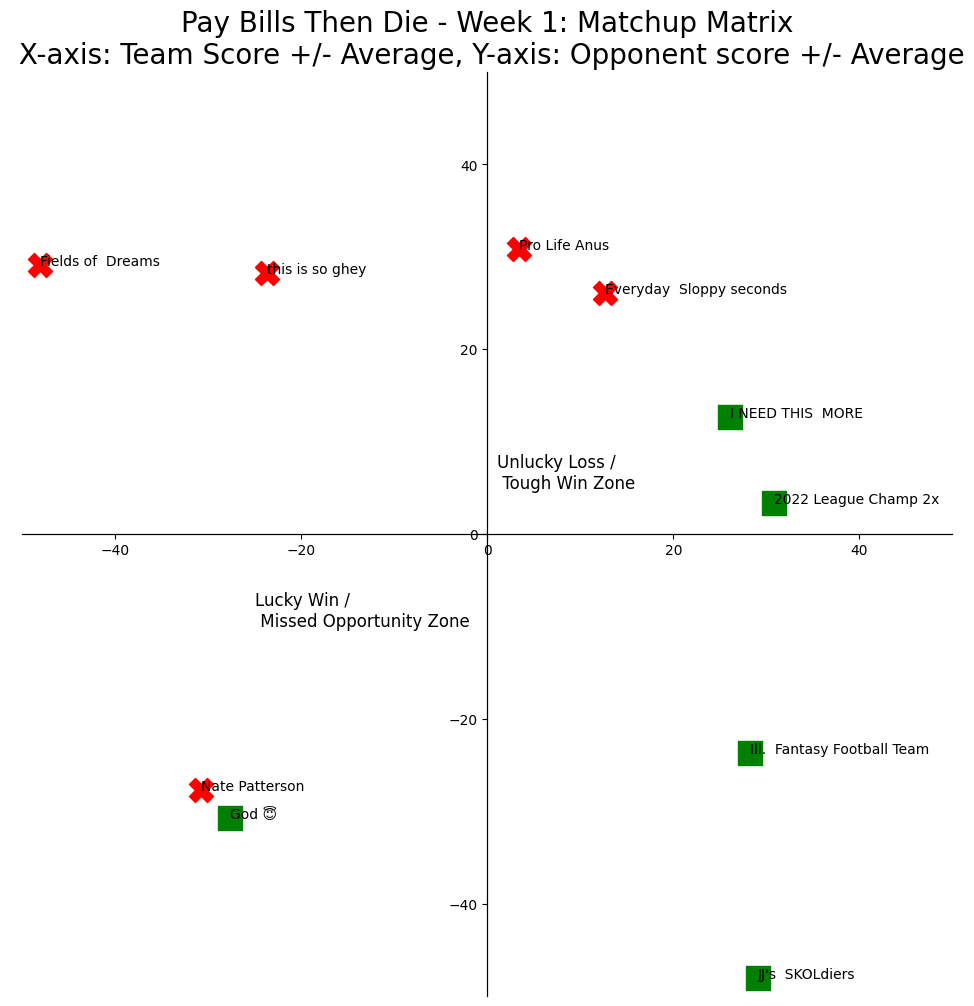

In [15]:
# Define plot size and autolayout
plt.rcParams["figure.figsize"] = [12, 12]
#plt.rcParams["figure.autolayout"] = True

# Define the subplot
fig, ax = plt.subplots()


# Plot the data
plt.scatter(away_win_df['Score1']- average_score, away_win_df['Score2'] - average_score, marker='s', c='green', s=300)
plt.scatter(away_loss_df['Score1'] - average_score, away_loss_df['Score2'] - average_score, marker='X', c='red', s=300)
plt.scatter(home_win_df['Score2']- average_score, home_win_df['Score1'] - average_score, marker='s', c='green', s=300)
plt.scatter(home_loss_df['Score2'] - average_score, home_loss_df['Score1']- average_score, marker='X', c='red', s=300)

# Loop through and annotate the away team names on the chart
for name in range(0, 10):
    try:
        plt.annotate(away_win_df['Name1'][name], (away_win_df['Score1'][name] - average_score, away_win_df['Score2'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(away_loss_df['Name1'][name], (away_loss_df['Score1'][name] - average_score, away_loss_df['Score2'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(home_win_df['Name2'][name], (home_win_df['Score2'][name] - average_score, home_win_df['Score1'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(home_loss_df['Name2'][name], (home_loss_df['Score2'][name] - average_score, home_loss_df['Score1'][name] - average_score), fontsize=10)
    except:
        pass


# Define axes' ranges - make this dynamic later
plt.xlim((-50, 50))
plt.ylim((-50, 50))


# Move left y-axis and bottom x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_position('center')
ax.spines['right'].set_position('center')

# Annotate the quadrants
plt.annotate("Unlucky Loss /\n Tough Win Zone", (1,5), fontsize=12);
plt.annotate("Lucky Win /\n Missed Opportunity Zone", (-25, -10), fontsize=12);

# Chart title
plt.title(
    f"Pay Bills Then Die - Week {1}: Matchup Matrix\n X-axis: Team Score +/- Average, Y-axis: Opponent score +/- Average",
    fontdict={'fontsize':20});